<a href="https://colab.research.google.com/github/NevesJulio/Exercicios_DL/blob/main/06_generalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Exercício

Usando o dataset MNIST já carregado (500 exemplos), compare três arquiteturas diferentes e identifique qual apresenta menor overfitting. Analise os gaps de loss e acurácia entre treinamento e validação.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Configuração para gráficos
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo utilizado: {device}')

Dispositivo utilizado: cuda


In [2]:
# Carregar o dataset MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalização específica do MNIST
])

# Carregar datasets completos
train_dataset_full = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

train_loader = DataLoader(
    Subset(train_dataset_full, range(400)),
    batch_size=64,
    shuffle=True
)

val_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

val_loader = DataLoader(
    Subset(val_dataset, range(100)),
    batch_size=64,
    shuffle=False
)


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.95MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]


### 4.2 Arquitetura da Rede Neural

In [9]:
class MNISTClassifier(nn.Module):
    """Rede neural simples para classificação MNIST."""

    def __init__(self, hidden_size=128):
        super(MNISTClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Testar a arquitetura
# model_test = MNISTClassifier(hidden_size=128)
# print(f'Arquitetura do modelo:')
# print(model_test)

# Contar parâmetros
# total_params = sum(p.numel() for p in model_test.parameters())
# trainable_params = sum(p.numel() for p in model_test.parameters() if p.requires_grad)
# print(f'\nTotal de parâmetros: {total_params:,}')
# print(f'Parâmetros treináveis: {trainable_params:,}')

In [32]:
class MNISTBase(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)


In [33]:
class MNISTBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)


In [34]:
class MNISTBNDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),

            nn.Linear(28*28, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),     # Dropout moderado

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)


In [35]:
models = {
    "small": MNISTBase(),
    "medium": MNISTBatchNorm(),
    "large": MNISTBNDropout()
}

### 4.3 Função de Treinamento e Avaliação

In [36]:
def train_mnist_model(model, train_loader, val_loader, epochs=20, lr=0.001):
    """Treina modelo MNIST e retorna histórico de métricas."""

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Treinamento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Avaliação no conjunto de validação
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # Calcular métricas da época
        train_loss_avg = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        val_loss_avg = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total

        train_losses.append(train_loss_avg)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss_avg)
        val_accuracies.append(val_acc)

        if (epoch + 1) % 5 == 0:
            print(f'Época {epoch+1}/{epochs}: '
                  f'Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.2f}% | '
                  f'Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%')

    return model, {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }

### 4.4 Experimento: Variando o Tamanho do Dataset de Treinamento

In [37]:
# Definir diferentes tamanhos de dataset para o experimento
batch_size = 64
epochs = 20

# Inicializar dicionários para armazenar resultados
results_by_size = {}
models_by_size = {}


In [38]:
# Executar experimentos para cada tamanho de dataset
for name, model in models.items():
    print(f"Treinando com a arquitetura {name}...")

    # Treinar modelo
    model, history = train_mnist_model(model,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=epochs,
        lr=0.001
    )

    # Armazenar resultados
    results_by_size[name] = history
    models_by_size[name] = model

    print(f"Concluído para {name}")

print("Todos os experimentos concluídos!")

Treinando com a arquitetura small...
Época 5/20: Train Loss: 0.2801, Train Acc: 93.25% | Val Loss: 0.5621, Val Acc: 82.00%
Época 10/20: Train Loss: 0.0374, Train Acc: 99.75% | Val Loss: 0.4718, Val Acc: 84.00%
Época 15/20: Train Loss: 0.0112, Train Acc: 100.00% | Val Loss: 0.4811, Val Acc: 83.00%
Época 20/20: Train Loss: 0.0053, Train Acc: 100.00% | Val Loss: 0.4937, Val Acc: 82.00%
Concluído para small
Treinando com a arquitetura medium...
Época 5/20: Train Loss: 0.2823, Train Acc: 98.75% | Val Loss: 0.6567, Val Acc: 84.00%
Época 10/20: Train Loss: 0.0732, Train Acc: 100.00% | Val Loss: 0.4857, Val Acc: 83.00%
Época 15/20: Train Loss: 0.0345, Train Acc: 100.00% | Val Loss: 0.4463, Val Acc: 85.00%
Época 20/20: Train Loss: 0.0193, Train Acc: 100.00% | Val Loss: 0.4216, Val Acc: 87.00%
Concluído para medium
Treinando com a arquitetura large...
Época 5/20: Train Loss: 0.5467, Train Acc: 92.50% | Val Loss: 0.8018, Val Acc: 82.00%
Época 10/20: Train Loss: 0.2242, Train Acc: 98.75% | Val Los

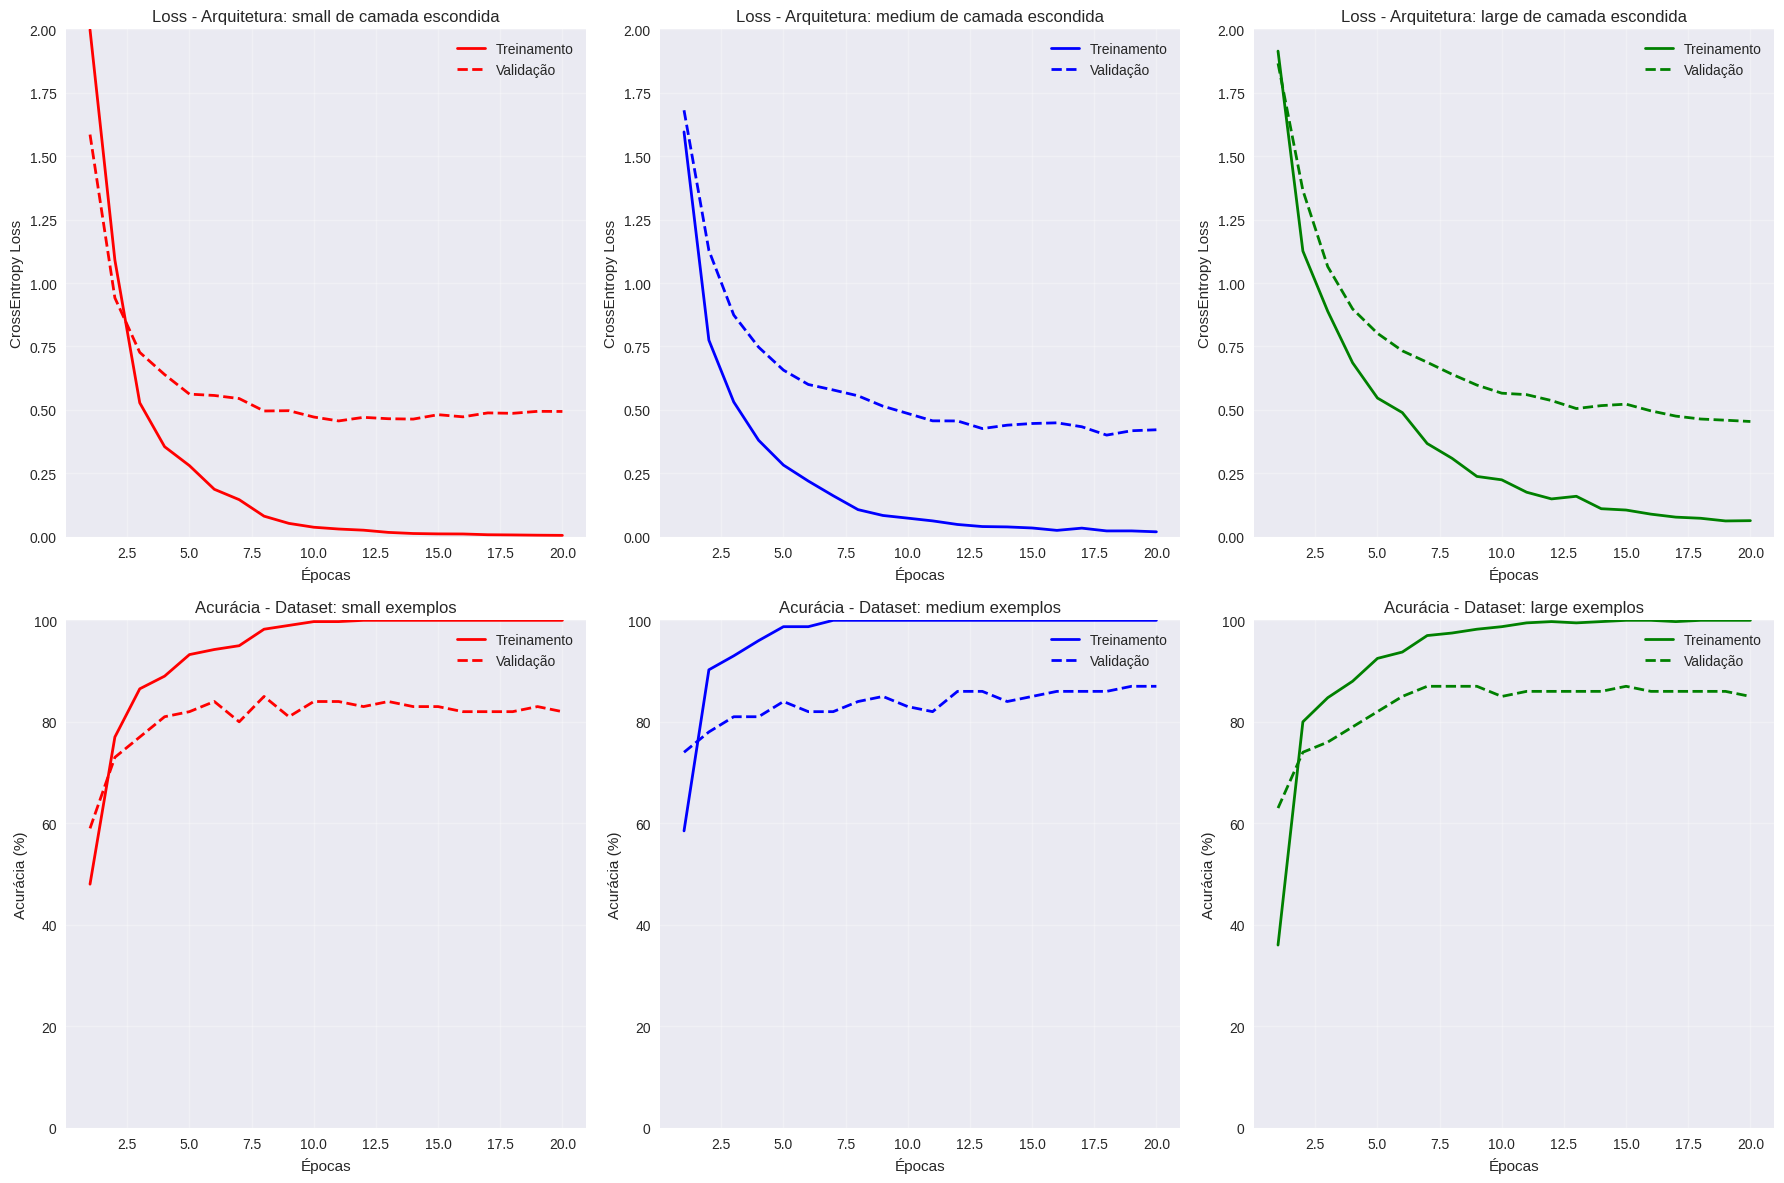

In [39]:
# Visualizar curvas de treinamento
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
colors = ['r', 'b', 'g']

for i, (name, history) in enumerate(results_by_size.items()):
    history = results_by_size[name]
    color = colors[i]

    # Curvas de loss
    ax_loss = axes[0, i]
    epochs_range = range(1, len(history['train_losses']) + 1)
    ax_loss.plot(epochs_range, history['train_losses'], f'{color}-', linewidth=2, label='Treinamento')
    ax_loss.plot(epochs_range, history['val_losses'], f'{color}--', linewidth=2, label='Validação')
    ax_loss.set_title(f'Loss - Arquitetura: {name} de camada escondida')
    ax_loss.set_xlabel('Épocas')
    ax_loss.set_ylabel('CrossEntropy Loss')
    ax_loss.legend()
    ax_loss.grid(True, alpha=0.3)
    ax_loss.set_ylim([0, 2])

    # Curvas de acurácia
    ax_acc = axes[1, i]
    ax_acc.plot(epochs_range, history['train_accuracies'], f'{color}-', linewidth=2, label='Treinamento')
    ax_acc.plot(epochs_range, history['val_accuracies'], f'{color}--', linewidth=2, label='Validação')
    ax_acc.set_title(f'Acurácia - Dataset: {name} exemplos')
    ax_acc.set_xlabel('Épocas')
    ax_acc.set_ylabel('Acurácia (%)')
    ax_acc.legend()
    ax_acc.grid(True, alpha=0.3)
    ax_acc.set_ylim([0, 100])

plt.tight_layout()
plt.show()

Embora tenha diversas arquiteturas o número baixo de exemplos limitou muito o trainemento, resultando em um Overfitting na maioria dos casos com as redes neurais.